In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 
%load_ext tensorboard

In [2]:
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.python.framework.ops import disable_eager_execution
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import tensorflow.keras.backend as kb
import yaml
import datetime
import glob
import numpy as np
import scipy.io as sio
import scipy.interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import collections
from collections import Counter 

In [3]:
from HelperFn.ExpData_Generator import TrainingGenerator
from HelperFn.ExpData_Generator import EvalTestGenerator
from HelperFn.utils import Params
from sklearn.metrics import r2_score
# from vis.visualization import visualize_saliency, visualize_cam, overlay

In [4]:
# Update MODEL_DIR and mini_EXP_name 
## folder contains: weights, yaml file, and figures

mini_EXP_name = 'archive_final_run'
exp_folder_path = 'experiments/'+ mini_EXP_name

MODEL_DIR = './experiments/'
DATA_DIR = '../../processed_input_data/'
NPY_FOLDER = 'slice_npy/'
F_MASTER = 'file_master'
ML_EXP = 'split_master/'
Train_Master = 'train_master.txt'
Eval_Master = 'eval_master.txt'
Test_Master = 'test_master.txt'
json_path = os.path.join(exp_folder_path, 'params.json')
params = Params(json_path)
mini_exp_list = ["archive_final_run","run_1"]

In [5]:
with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle:
    raw_history = yaml.load(filehandle, Loader = yaml.Loader)

val_loss = raw_history['val_loss']
train_accuracy = raw_history['custom_accuracy_2SD']
val_accuracy = raw_history['val_custom_accuracy_2SD']
best_model_EPOCH = val_loss.index(min(val_loss)) + 1 
selected_history = {}
selected_history['Bmodel_EPOCH'] = best_model_EPOCH
selected_history['min_val_loss'] =  np.round(min(val_loss),4)
selected_history['max_train_accuracy'] =  np.round(max(train_accuracy),4)
selected_history['max_val_accuracy'] =  np.round(max(val_accuracy),4)
selected_history['Bmodel_train_accuracy'] =  np.round(train_accuracy[val_loss.index(min(val_loss))],4)
selected_history['Bmodel_val_accuracy'] = np.round(val_accuracy[val_loss.index(min(val_loss))],4)

In [6]:
selected_history

{'Bmodel_EPOCH': 41,
 'min_val_loss': 2.1378,
 'max_train_accuracy': 0.9361,
 'max_val_accuracy': 0.9702,
 'Bmodel_train_accuracy': 0.9286,
 'Bmodel_val_accuracy': 0.9659}

In [7]:
def Plot_Loss(mini_exp_list, selected_exp,final_EPOCH, 
              l_width, l_alpha, marker_size, fig_size):
    
    ### Part 1: plot of the selected exp in solid 
    
    ##extract full raw history from selected experiments 
    selected_exp_path = MODEL_DIR + '/' + selected_exp
    with open(selected_exp_path + "/raw_history.yaml", "r") as filehandle2:
            raw_history = yaml.load(filehandle2, Loader = yaml.Loader)
    
    train_loss = raw_history['loss']
    val_loss = raw_history['val_loss']
    
    
    ## plot train loss
    plt.plot(train_loss, color = '#1f77b4', 
                 linewidth=l_width*2, 
                 alpha=l_alpha*2, label = 'Train_Loss (best model)')
    
    ## plot eval loss
    
    #Extract saved_bmodel from one selected experiment
    saved_bmodel = glob.glob(selected_exp_path + '/*.hdf5',  
           recursive = True)  
    b_ep_list =[]
    for file in saved_bmodel: 
        b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
        sorted_b_ep_list = sorted(b_ep_list)
        b_ep_list = sorted_b_ep_list
    Val_Loss_list = list(val_loss[i] for i in b_ep_list)       
    plt.plot(b_ep_list,Val_Loss_list, color = 'darkorange', 
                 marker='o', markersize=marker_size*2.5, 
                 linewidth=l_width*2, linestyle='solid', 
                 alpha=l_alpha*2, label = 'Eval_Loss (best model)')
    plt.plot(val_loss,color = 'darkorange', 
                 linestyle='dashed', linewidth=l_width*1.5, 
                 alpha=l_alpha)

    ### Part 2: plot all exp in transparants  
    
    ##extract full raw history from all experiments
    for m_idx, m in enumerate(mini_exp_list):
        exp_folder_path = MODEL_DIR + '/' + m
        with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
            raw_history = yaml.load(filehandle2, Loader = yaml.Loader)
        train_loss = raw_history['loss']
        val_loss = raw_history['val_loss']
        
        #Extract saved_bmodel to highlight the improved loss
        saved_bmodel = glob.glob(exp_folder_path + '/*.hdf5',  
           recursive = True)
        b_ep_list =[]
        for file in saved_bmodel: 
            b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
            sorted_b_ep_list = sorted(b_ep_list)
            b_ep_list = sorted_b_ep_list
                    
        Val_Loss_list = list(val_loss[i] for i in b_ep_list)
        
        if m_idx == 0:
            train_label = 'Train_Loss (repeated experiments)'
            eval_label = 'Eval_Loss (repeated experiments)'
        else:
            train_label = None
            eval_label = None
        
        #plot all train loss
        plt.plot(train_loss, color = '#1f77b4', 
                 linewidth=l_width, 
                 alpha=l_alpha, label = train_label)
        
        #plot saved models with markers 
        plt.plot(b_ep_list,Val_Loss_list, color = 'darkorange', 
                 marker='o', markersize=marker_size, 
                 linewidth=l_width, linestyle='solid', 
                 alpha=l_alpha, label = eval_label)
        #plot all eval loss with dashed lines
        plt.plot(val_loss,color = 'darkorange', 
                 linestyle='dashed', linewidth=l_width*0.8, 
                 alpha=l_alpha*0.5)
        
        
#   plt.title(str(keyword), fontsize = 20)
    plt.rcParams["font.family"] = 'Helvetica'
    plt.ylabel('Loss',fontsize = 16)
    plt.xlabel('Epoch', fontsize = 16)
    plt.xlim([0,final_EPOCH])
    plt.ylim([0,100])
    lgnd = plt.legend(loc='upper right',fontsize = 12)
    lgnd.legendHandles[1]._legmarker.set_markersize(10)
    
    lgnd.legendHandles[1]._legmarker.set_markersize(10)
    plt.savefig('Loss_All.svg', dpi=900, edgecolor='w',
        orientation='portrait', format='svg',
        transparent=False, bbox_inches=None, pad_inches=0.1)

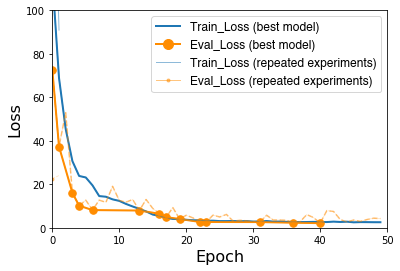

In [8]:
# Plot_Loss(mini_exp_list, selected_exp = 'LR5e-3_ReducedImAug5',final_EPOCH = 50, l_width = 1, l_alpha = 0.5, marker_size = 3, fig_size =(10,10))
Plot_Loss(mini_exp_list, selected_exp = 'archive_final_run',final_EPOCH = 50, l_width = 1, l_alpha = 0.5, marker_size = 3, fig_size =(10,10))

In [9]:
def Plot_Accuracy(mini_exp_list, selected_exp,final_EPOCH, 
              l_width, l_alpha, marker_size, fig_size):
    
    ### Part 1: plot of the selected exp in solid 
    
    ##extract full raw history from selected experiments 
    selected_exp_path = MODEL_DIR + '/' + selected_exp
    with open(selected_exp_path + "/raw_history.yaml", "r") as filehandle2:
            raw_history = yaml.load(filehandle2, Loader = yaml.Loader)
    
    train_acc = raw_history['custom_accuracy_2SD']
    val_acc = raw_history['val_custom_accuracy_2SD']*100
    
    
    ## plot train acc
    plt.plot(train_acc, color = '#1f77b4', 
                 linewidth=l_width*2, 
                 alpha=l_alpha*2, label = 'Train_Accuracy (best model)')
    
    ## plot eval acc
    
    #Extract saved_bmodel from one selected experiment
    saved_bmodel = glob.glob(selected_exp_path + '/*.hdf5',  
           recursive = True)  
    b_ep_list =[]
    for file in saved_bmodel: 
        b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
        sorted_b_ep_list = sorted(b_ep_list)
        b_ep_list = sorted_b_ep_list
    Val_Acc_list = list(val_acc[i] for i in b_ep_list)       
    plt.plot(b_ep_list,Val_Acc_list, color = 'darkorange', 
                 marker='o', markersize=marker_size*2.5, 
                 linewidth=l_width*2, linestyle='solid', 
                 alpha=l_alpha*2, label = 'Eval_Accuracy (best model)')
    plt.plot(val_acc,color = 'darkorange', 
                 linestyle='dashed', linewidth=l_width*1.5, 
                 alpha=l_alpha)

    ### Part 2: plot all exp in transparants  
    
    ##extract full raw history from all experiments
    for m_idx, m in enumerate(mini_exp_list):
        exp_folder_path = MODEL_DIR + '/' + m
        with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
            raw_history = yaml.load(filehandle2, Loader = yaml.Loader)
        train_acc = raw_history['custom_accuracy_2SD']*100
        val_acc = raw_history['val_custom_accuracy_2SD']*100
        
        #Extract saved_bmodel to highlight the improved acc
        saved_bmodel = glob.glob(exp_folder_path + '/*.hdf5',  
           recursive = True)
        b_ep_list =[]
        for file in saved_bmodel: 
            b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
            sorted_b_ep_list = sorted(b_ep_list)
            b_ep_list = sorted_b_ep_list
                    
        Val_Acc_list = list(val_acc[i] for i in b_ep_list)
        
        
        if m_idx == 0:
            train_label = 'Train_Accuracy (repeated experiments)'
            eval_label = 'Eval_Accuracy (repeated experiments)'
        else:
            train_label = None
            eval_label = None
        
        
        #plot all train loss
        plt.plot(train_acc, color = '#1f77b4', 
                 linewidth=l_width, 
                 alpha=l_alpha, label = train_label)
        
        #plot saved models with markers 
        plt.plot(b_ep_list,Val_Acc_list, color = 'darkorange', 
                 marker='o', markersize=marker_size, 
                 linewidth=l_width, linestyle='solid', 
                 alpha=l_alpha, label = eval_label)
        #plot all eval loss with dashed lines
        plt.plot(val_acc,color = 'darkorange', 
                 linestyle='dashed', linewidth=l_width*0.8, 
                 alpha=l_alpha*0.5)
    
    plt.rcParams["font.family"] = 'Helvetica'
    plt.ylabel('Accuracy ',fontsize = 16)
    plt.xlabel('Epoch', fontsize = 16)
    plt.xlim([0,final_EPOCH])
    plt.ylim([0,1])
    
    lgnd = plt.legend(loc='lower right',fontsize = 12)
    lgnd.legendHandles[1]._legmarker.set_markersize(10)
    plt.savefig('Acc_All.svg', dpi=900, edgecolor='w',
        orientation='portrait', format='svg',
        transparent=False, bbox_inches=None, pad_inches=0.1)

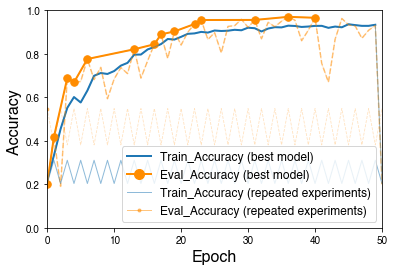

In [10]:
# Plot_Accuracy(mini_exp_list, selected_exp = 'LR5e-3_ReducedImAug5',final_EPOCH = 50, l_width = 1, l_alpha = 0.5, marker_size = 3, fig_size =(10,10))
Plot_Accuracy(mini_exp_list, selected_exp = 'archive_final_run',final_EPOCH = 50, l_width = 1, l_alpha = 0.5, marker_size = 3, fig_size =(10,10))

In [11]:
def MSE_wSD_loss(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    mse = tf.keras.losses.MeanSquaredError()
    return mse(Y_true[:, 0], KE_pred)/((Y_true[:, 1])**2+1e-5)

def custom_accuracy_2SD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),2*SD_true), dtype = "float32"))
    return C_accuracy 

def custom_accuracy_SD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),SD_true), dtype = "float32"))
    return C_accuracy 

def custom_accuracy_avSD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),0.08), dtype = "float32"))
    return C_accuracy 

def custom_accuracy_mostSD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),0.2), dtype = "float32"))
    return C_accuracy 

In [12]:
# mini_e = 'LR5e-3_ReducedImAug5'
mini_e = 'archive_final_run'
exp_folder_path = MODEL_DIR + '/' + mini_e
files = glob.glob(exp_folder_path + '/*.hdf5',  
                   recursive = True)
saved_model = []
for file in files:
    print(file.split('/')[-1])
    saved_model.append(file.split('/')[-1])

weights-improvement-23-0.94.hdf5
weights-improvement-17-0.84.hdf5
weights-improvement-07-0.78.hdf5
weights-improvement-32-0.96.hdf5
weights-improvement-05-0.67.hdf5
weights-improvement-20-0.90.hdf5
weights-improvement-14-0.82.hdf5
weights-improvement-18-0.89.hdf5
weights-improvement-24-0.96.hdf5
weights-improvement-41-0.97.hdf5
weights-improvement-04-0.69.hdf5
weights-improvement-01-0.20.hdf5
weights-improvement-37-0.97.hdf5
weights-improvement-02-0.42.hdf5


In [13]:
selectedE = 41
selected_weights = ''
for file in saved_model:
    if file.split('-')[-2][0:2]==str(selectedE):
        selected_weights = file
print (selected_weights)  

weights-improvement-41-0.97.hdf5


In [14]:
filepath = exp_folder_path + '/' +selected_weights
print(filepath)
best_model = tf.keras.models.load_model(filepath, custom_objects = 
                                        {"MSE_wSD_loss":MSE_wSD_loss, 
                                "custom_accuracy_2SD": custom_accuracy_2SD,
                                "custom_accuracy_SD": custom_accuracy_SD,
                                "custom_accuracy_avSD": custom_accuracy_avSD})

./experiments//archive_final_run/weights-improvement-41-0.97.hdf5


In [15]:
input_slice_shape = (128,64,1)
batch_size = params.batch_size
MMT = params.bn_momentum
LR = params.learning_rate
num_channels = params.num_channels
#EPOCH = params.num_epochs

In [16]:
#apply best model to three subset of data
batch_size = 1 
##Training
train_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Train_Master, 
                                       batch_size = batch_size, 
                                       data_dir=DATA_DIR, shuffle = False)
train_label = np.hstack([batch[1][:,0] for batch in train_generator])
train_SD = np.hstack([batch[1][:,1] for batch in train_generator])
train_pred = best_model.predict(x=train_generator)

##Validation
eval_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Eval_Master, 
                                         batch_size = batch_size, 
                                         data_dir=DATA_DIR, shuffle = False)
eval_label = np.hstack([batch[1][:,0] for batch in eval_generator])
eval_SD = np.hstack([batch[1][:,1] for batch in eval_generator])
eval_pred = best_model.predict(x=eval_generator)

##Testing
test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Test_Master, 
                                   batch_size = batch_size, 
                                   data_dir=DATA_DIR, shuffle = False)
test_label = np.hstack([batch[1][:,0] for batch in test_generator])
test_SD = np.hstack([batch[1][:,1] for batch in test_generator])
test_pred = best_model.predict(x=test_generator)

7998
7998


2022-03-02 21:34:11.680946: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-02 21:34:11.682758: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3064
3064
1532
1532


In [17]:
train_LSP = [train_label,train_SD,train_pred]
eval_LSP = [eval_label,eval_SD,eval_pred]
test_LSP = [test_label,test_SD,test_pred]
generator_LSP = [train_LSP,eval_LSP,test_LSP]

In [18]:
def plotting_with_TS(LSP, mode):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    label = LSP[0]
    SD = LSP[1]
    pred = LSP[2].flatten()
    idx = np.abs(pred-label) > 2*SD
    error_pct = np.round(100*np.sum(idx)/len(pred), 1)
    text_accuracy = str(100 - error_pct) + '%'
    
    fig, ax = plt.subplots(figsize=(6,6), dpi=900) 
    
    ax.plot(pred, label,'bo',alpha=0.15, label=f'Correct   ' +  str(100 - error_pct) + '%') 
    ax.plot(pred[idx], label[idx], 'ro',alpha=0.15, label=f'Incorrect   ' + str(error_pct) + '%') 
    ax.plot([0,1], [0,1], 'k',alpha=0.5, linewidth=0.5)
    ax.set_title(str(mode), fontsize = 24)
#     ax.text(0.3, 0.85, text_error, fontsize = 12, style = 'italic', weight='normal',
#             horizontalalignment = 'center',transform=ax.transAxes)
    ax.set_ylabel('Truth', fontsize =20)
    ax.set_xlabel('Prediction', fontsize = 20)
    lgnd = ax.legend(loc='upper left',prop={'size': 16} )
    lgnd.legendHandles[0]._legmarker.set_markersize(18)
    lgnd.legendHandles[1]._legmarker.set_markersize(18)
    plt.savefig(str(mode)  + '_result.svg', dpi=900, edgecolor='w',
        orientation='portrait', format='svg',
        transparent=False, bbox_inches=None, pad_inches=0.1)
    
    plt.tight_layout()
    plt.show

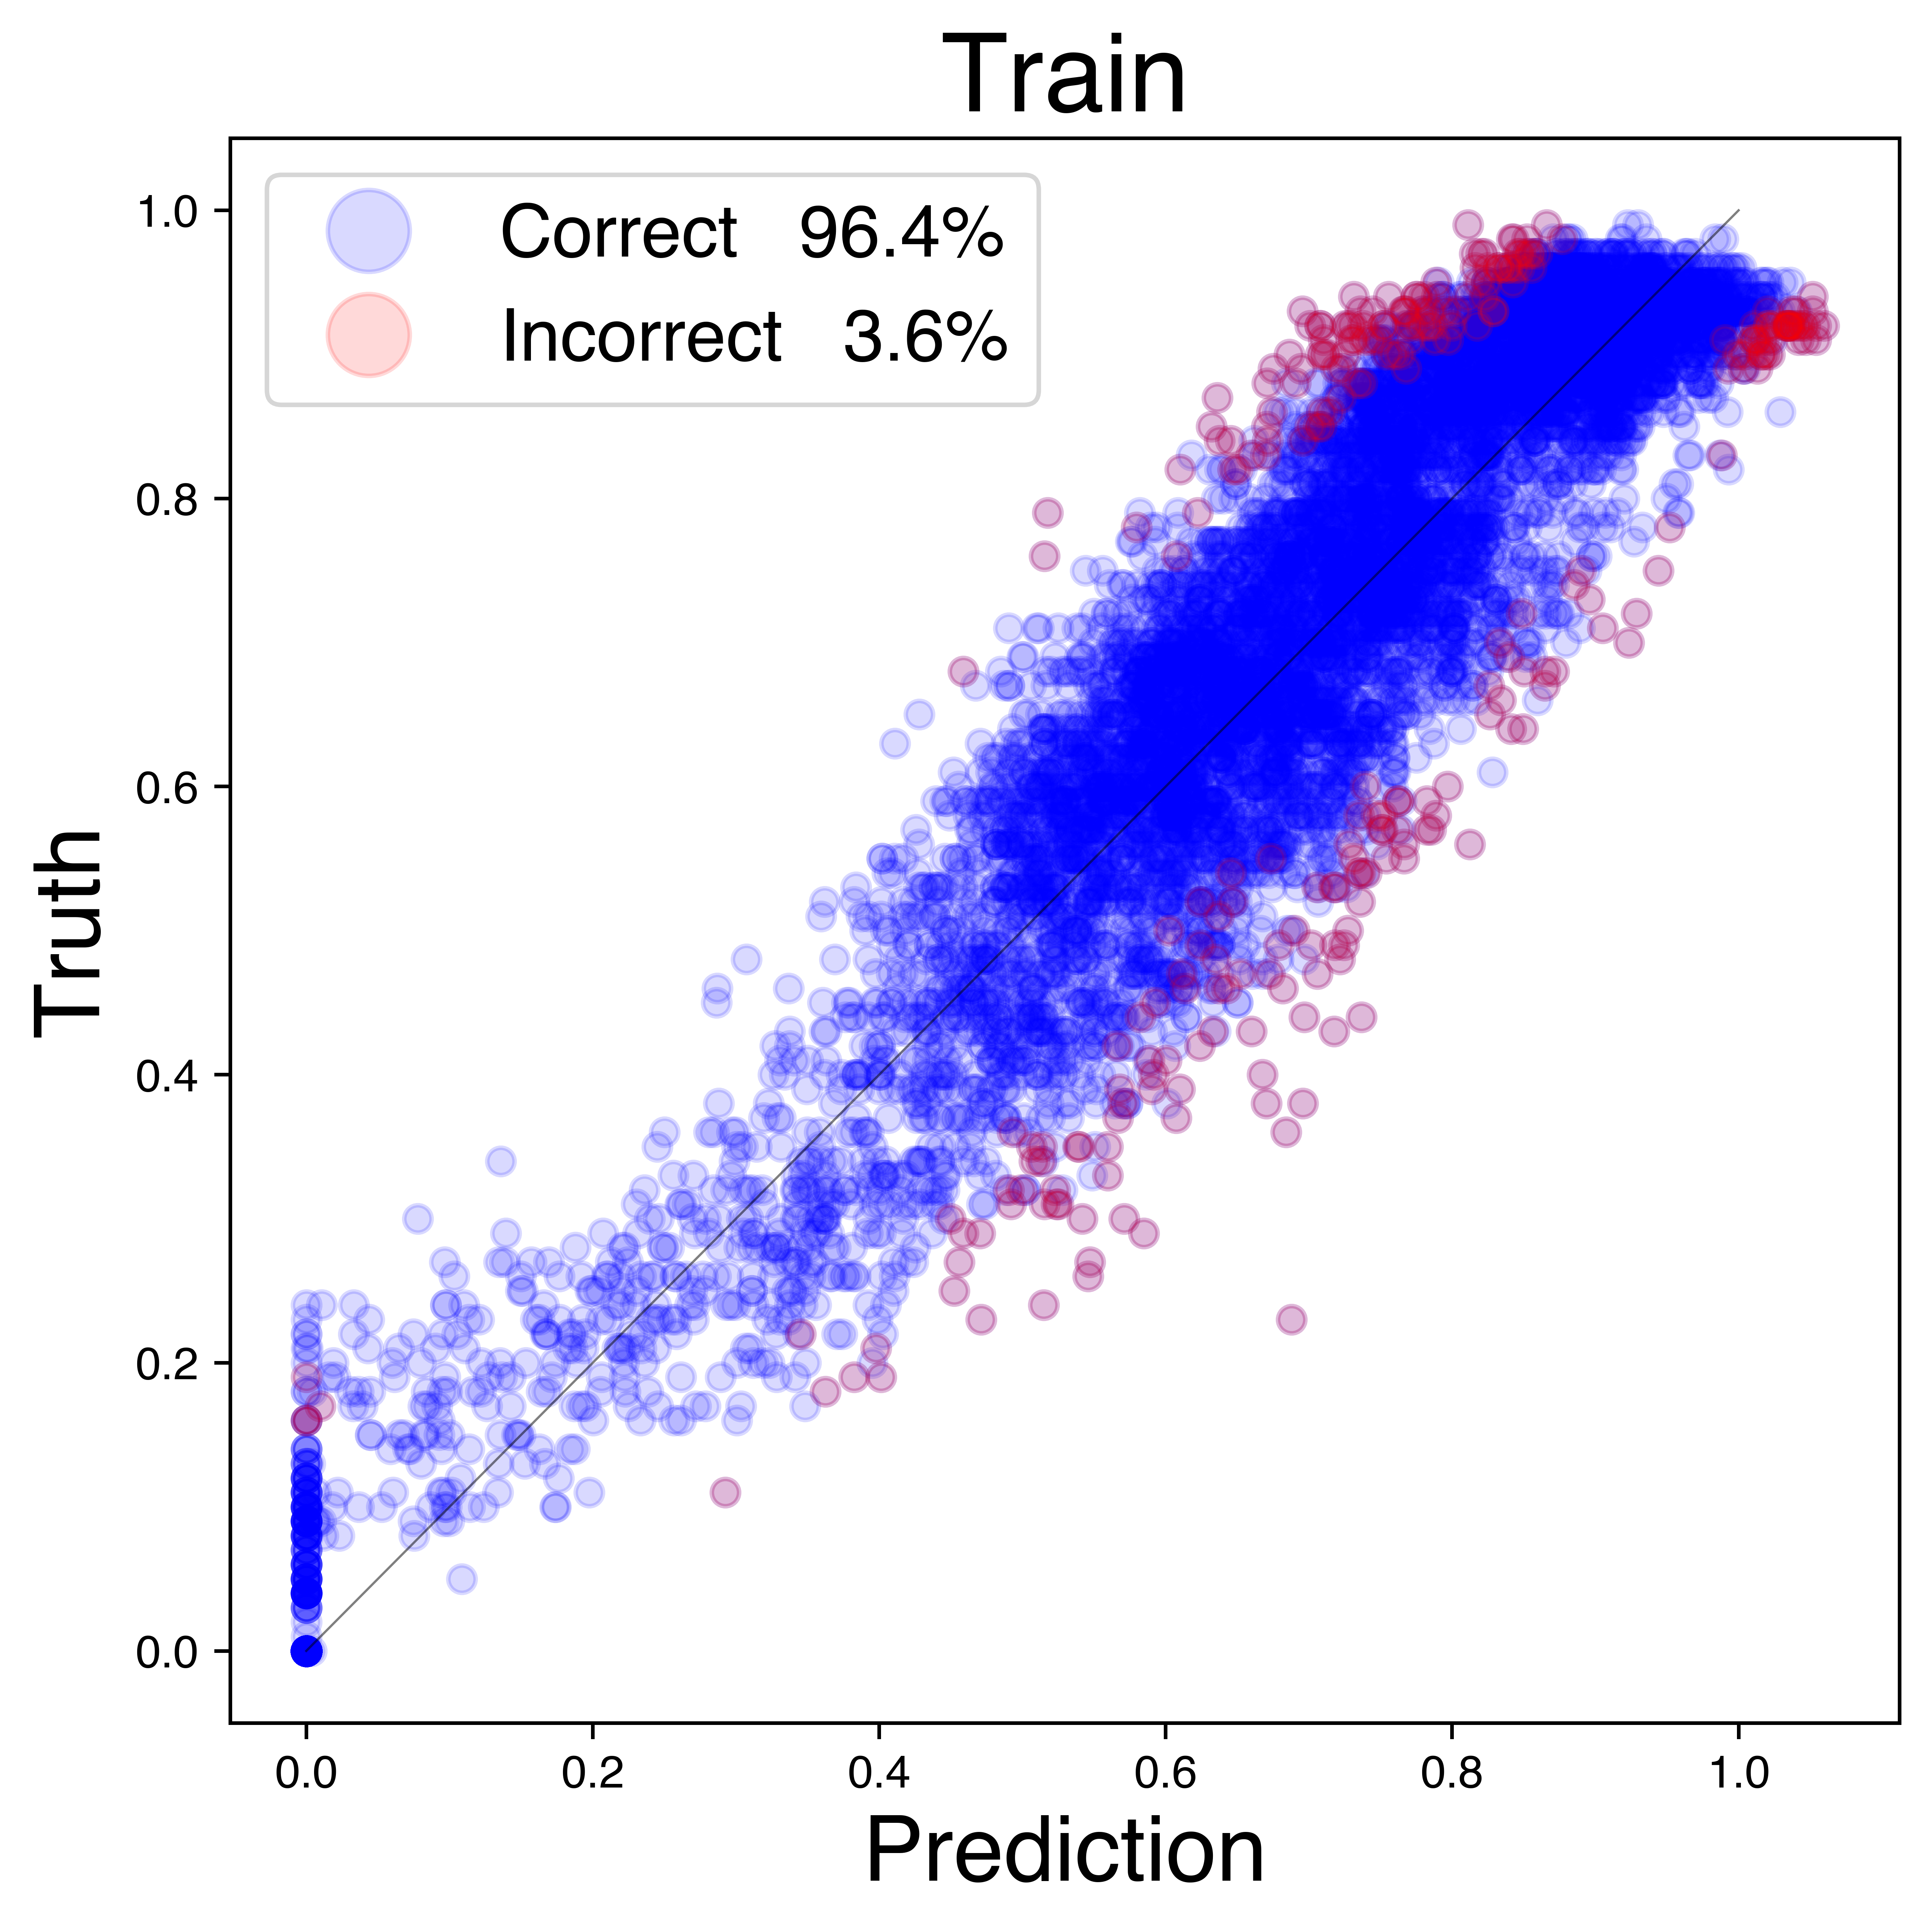

In [19]:
plotting_with_TS(train_LSP, 'Train')

In [20]:
def plotting_with_TS_V(generator_LSP, mode, EXP, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,12))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
#         if len(pred) == len(label):
#             print(len(pred))
        idx = np.abs(pred-label) > 2*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 2)
        

        ax.plot(pred, label,'b.',alpha=0.25, label=f'Correct')
        ax.plot(pred[idx], label[idx], 'r.',alpha=0.25, label=f'Incorrect')
        ax.plot([0, 1], [0, 1], 'k',alpha=0.8)
        ax.set_title(str(m), fontsize = 24)
        text_error = '% error (>2SD) = ' +str(error_pct) + '%'
        ax.text(0.7, 0.1, text_error, fontsize = 12,
                horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='best')
        ax.set_ylabel('Truth', fontsize =18)
    axs[2].set_xlabel('Prediction', fontsize = 18)

    plt.tight_layout()
    plt.show


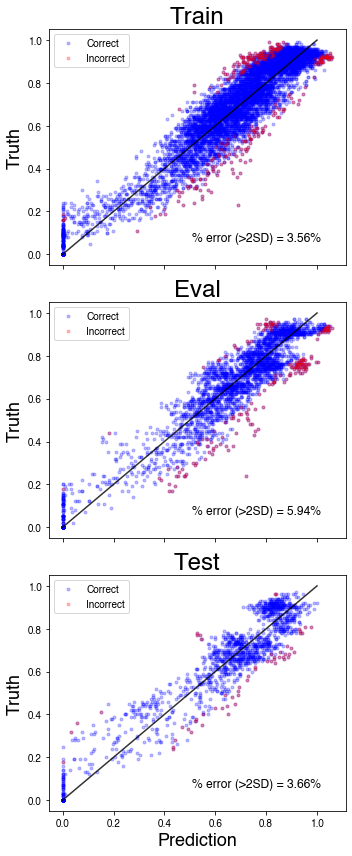

In [21]:
plotting_with_TS_V(generator_LSP, ['Train', 'Eval', 'Test'], EXP = 7.2, selected_EP = selectedE)

In [22]:
def plotting_with_TS_H(generator_LSP, mode, EXP, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
        if len(pred) == len(label):
            print(len(pred))
        idx = np.abs(pred-label) > 2*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 2)
        

        ax.plot(pred, label,'b.',alpha=0.25, label=f'Correct')
        ax.plot(pred[idx], label[idx], 'r.',alpha=0.25, label=f'Incorrect')
        ax.plot([0, 1], [0, 1], 'k',alpha=0.4)
        ax.set_title(str(m), fontsize = 24)
        text_error = '% error (>2SD) = ' +str(error_pct) + '%'
        ax.text(0.7, 0.1, text_error, fontsize = 14,
                horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='best')
        ax.set_xlabel('Prediction', fontsize =18)
    axs[0].set_ylabel('Truth', fontsize = 18)

    plt.tight_layout()
    plt.show

7998
3064
1532


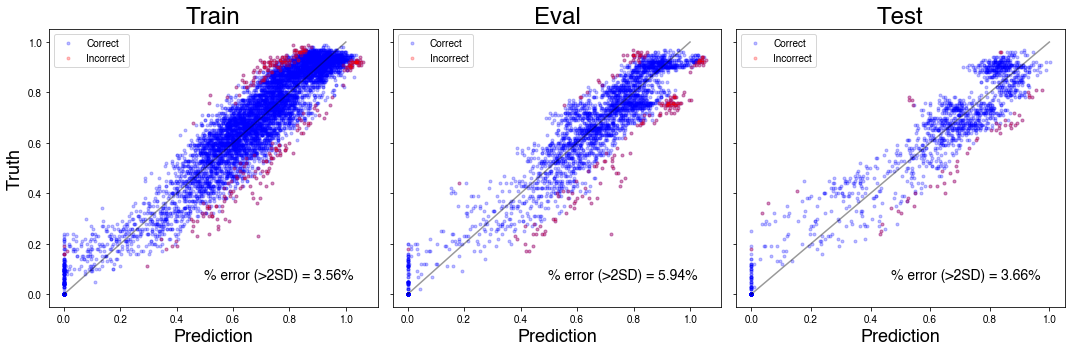

In [23]:
plotting_with_TS_H(generator_LSP, ['Train', 'Eval', 'Test'], EXP = 7.2, selected_EP = selectedE)

In [24]:
def plotting_all_scaled(generator_LSP, mode, EXP, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
        if len(pred) == len(label):
            print(len(pred))
        idx = np.abs(pred-label) > 2*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 2)

        repeats_all = list(zip(label, pred))
        weight_counter_all = Counter(repeats_all)
        weights_all = [weight_counter_all[(label[i], pred[i])] for i, _ in enumerate(label)]

        
        repeats = list(zip(label[idx], pred[idx]))
        weight_counter = Counter(repeats)
        weights = [weight_counter[(label[idx][i], pred[idx][i])] for i, _ in enumerate(label[idx])]
 

        ax.set_title(str(m), fontsize = 24)
        ax.scatter(pred, label, s=weights_all, c = 'blue', label=f'Correct')
#         ax.plot(pred, label,'bx',alpha=0.25, label=f'Correct')
#         ax.plot(pred[idx], label[idx], 'rx',alpha=0.25, label=f'Incorrect')
        ax.scatter(pred[idx], label[idx], s=weights, c = 'red', label=f'InCorrect')


        ax.plot([0, 1], [0, 1], 'k',alpha=0.8)
        text_error = '% error (>2SD) = ' +str(error_pct) + '%'
        ax.text(0.7, 0.1, text_error, fontsize = 14,
                horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='best')
        ax.set_xlabel('Prediction', fontsize =18)
        print('max_repeat: ' + str(np.max(weights)) +'/' +str(len(label)))
    axs[0].set_ylabel('Truth', fontsize = 18)

    plt.tight_layout()
    plt.show

7998
max_repeat: 2/7998
3064
max_repeat: 1/3064
1532
max_repeat: 1/1532


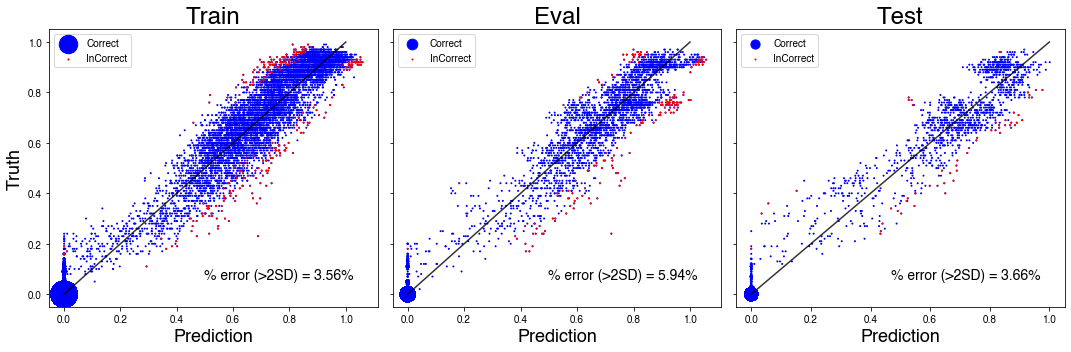

In [25]:
plotting_all_scaled(generator_LSP, ['Train', 'Eval', 'Test'], EXP = 7.2, selected_EP = selectedE)

In [26]:
def plotting_EXP(generator, pred, label, SD, mode, top_ith, num_sample):
      ## selecting outliers 
    y= pred.flatten()
    x= label
    if len(x) == len(y):
        print('size_data_all:',len(x))
    idx = np.abs(x-y) > 2*SD
    print('size_data_meetTS:', np.sum(idx))
    print('custom_2SD_Accuracy',(1-np.sum(idx)/len(x))*100, '%' )
    
  
    pred_outlier = np.round(y[idx],2)
    truth_outlier =np.round(x[idx],2)
    diff = np.round(np.abs(pred_outlier - truth_outlier),2)

        ##indexing from large to small for outlier 
    outlier_idx = np.argsort(diff)[::-1]
    y_outlier = pred_outlier[outlier_idx]
    x_outlier = truth_outlier[outlier_idx]
    offset_outlier = np.round(x_outlier-y_outlier,2)
        ## print top rank (num_sample) by the size of errors
    print('pred_outlier: ', y_outlier[top_ith:top_ith+num_sample])
    print('truth_outlier: ', x_outlier[top_ith:top_ith+num_sample])
    
    ##creating fault map of those outliers 
    CMAP = plt.cm.binary
    minCMAP = 0
    maxCMAP = 1
    ncols = num_sample
    print('Top_nth_Outier > 2SD: ', top_ith, '-', top_ith+ncols)
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(20,10))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
#     cbar = fig.colorbar(mappable, ax = axs.ravel().tolist(), 
#                     orientation='horizontal', fraction=0.05)
#     cbar.ax.tick_params(axis='x', labelsize=20)
    for i in range(ncols):
        filename = generator.filenames[:len(pred)][idx][outlier_idx][top_ith:top_ith+ncols][i]
        print(filename)
        fig_title = (filename[0:24])
        print(fig_title)
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
        prediction = y_outlier[top_ith:top_ith+ncols]
        label = x_outlier[top_ith:top_ith+ncols]
        offset = offset_outlier[top_ith:top_ith+ncols]
        two_SD = 2*SD[idx][outlier_idx][top_ith:top_ith+ncols]
        result = np.abs(offset) < np.round(2*SD[idx][outlier_idx][top_ith:top_ith+ncols],2)
        EXP = str(filename[0:8]) + '/w'+ str(filename[22:30])
        
        FontSize = 30
        
        text_label = axs[i].text(30,20, 'Label: ' 
                                     + str(label[i]), 
                                     fontsize =FontSize, 
                                     ha="center", va="center")
        text_prediction = axs[i].text(30,30, 'Pred: ' + str(prediction[i]), 
                                      fontsize =FontSize,
                                       ha="center", va="center")
        text_2SD = axs[i].text(30,40, '2SD: ' + str(two_SD[i]), 
                                      fontsize =FontSize,
                                       ha="center", va="center")

        if result[i] == True:
            text_result = axs[i].text(30,90, 'Diff: |'  + str(offset[i]) + '|' , 
                                fontsize =FontSize, ha="center", 
                                      va="center", color="b")
        else:
            text_result = axs[i].text(30,90, 'Diff: |'  + str(offset[i]) + '|' ,
                                fontsize =FontSize, ha="center", 
                                      va="center", color="r")
        axs[i].imshow(data[:, :, 1], norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )
#     plt.savefig(MODEL_DIR +'/' + str(mode) + '_outlier.png')

size_data_all: 1532
size_data_meetTS: 56
custom_2SD_Accuracy 96.34464751958225 %
pred_outlier:  [0.83 0.62 0.87 0.43 0.5 ]
truth_outlier:  [0.64 0.43 0.68 0.25 0.32]
Top_nth_Outier > 2SD:  20 - 25
EB_050_2/0.64_0.09_win_0_t_180_EB_050_2_cfuv.npy
EB_050_2/0.64_0.09_win_0
EB_150_3/0.43_0.08_win_4_t_091_EB_150_3_cfuv.npy
EB_150_3/0.43_0.08_win_4
EB_050_2/0.68_0.08_win_0_t_191_EB_050_2_cfuv.npy
EB_050_2/0.68_0.08_win_0
EB_050_2/0.25_0.09_win_0_t_065_EB_050_2_cfuv.npy
EB_050_2/0.25_0.09_win_0
EB_150_3/0.32_0.07_win_4_t_083_EB_150_3_cfuv.npy
EB_150_3/0.32_0.07_win_4


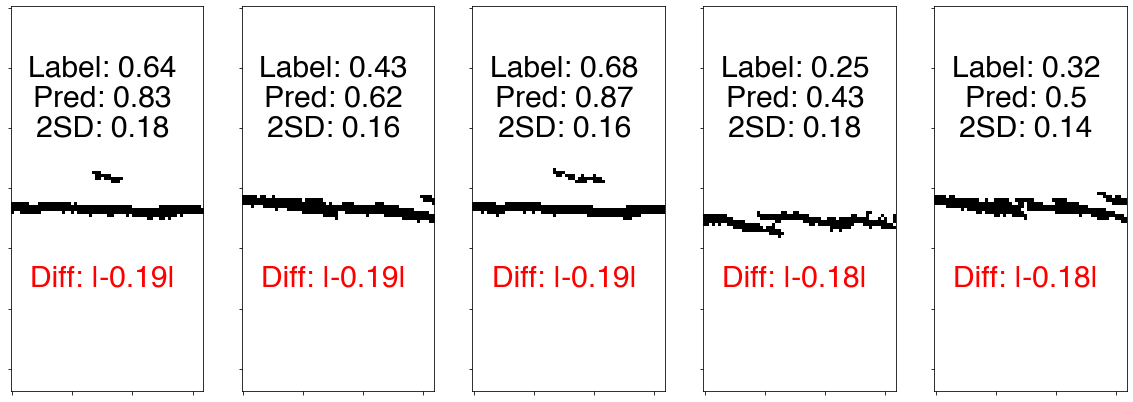

In [27]:
plotting_EXP(test_generator, test_pred, test_label, test_SD, 'test', 20, 5)

size_data_all: 1532
size_data_meetTS: 56
custom_2SD_Accuracy 96.34464751958225 %
pred_outlier:  [0.87 0.43]
truth_outlier:  [0.68 0.25]
Top_nth_Outier > 2SD:  22 - 24
EB_050_2/0.68_0.08_win_0_t_191_EB_050_2_cfuv.npy
EB_050_2/0.68_0.08_win_0
EB_050_2/0.25_0.09_win_0_t_065_EB_050_2_cfuv.npy
EB_050_2/0.25_0.09_win_0


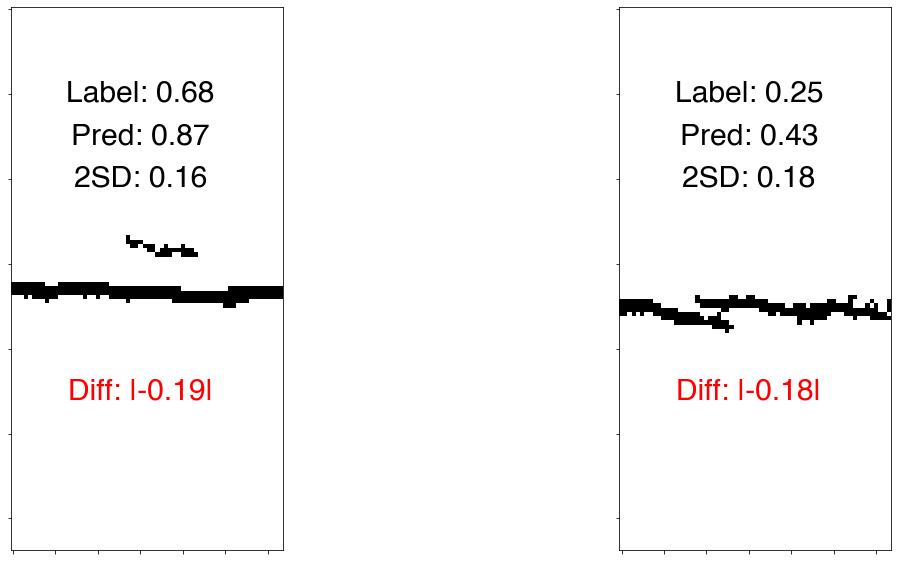

In [28]:
plotting_EXP(test_generator, test_pred, test_label, test_SD, 'test', 22, 2)

In [30]:
def plotting_EXP_curl(generator, pred, label, SD, mode, top_ith, num_sample):
      ## selecting outliers 
    y= pred.flatten()
    x= label
    if len(x) == len(y):
        print('size_data_all:',len(x))
    idx = np.abs(x-y) > 2*SD
    print('size_data_meetTS:', np.sum(idx))
    print('custom_2SD_Accuracy',(1-np.sum(idx)/len(x))*100, '%' )
    
  
    pred_outlier = np.round(y[idx],2)
    truth_outlier =np.round(x[idx],2)
    diff = np.round(np.abs(pred_outlier - truth_outlier),2)

        ##indexing from large to small for outlier 
    outlier_idx = np.argsort(diff)[::-1]
    y_outlier = pred_outlier[outlier_idx]
    x_outlier = truth_outlier[outlier_idx]
    offset_outlier = np.round(x_outlier-y_outlier,2)
        ## print top rank (num_sample) by the size of errors
    print('pred_outlier: ', y_outlier[top_ith:top_ith+num_sample])
    print('truth_outlier: ', x_outlier[top_ith:top_ith+num_sample])
    
    ##creating fault map of those outliers 
    CMAP = plt.cm.seismic
    minCMAP = -0.01
    maxCMAP = 0.01
    ncols = num_sample
    print('Top_nth_Outier > 2SD: ', top_ith, '-', top_ith+ncols)
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(36,8))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    cbar = fig.colorbar(mappable, ax = axs.ravel().tolist(), 
                    orientation='horizontal', fraction=0.05)
    cbar.ax.tick_params(axis='x', labelsize=20)
    for i in range(ncols):
        filename = generator.filenames[:len(pred)][idx][outlier_idx][top_ith:top_ith+ncols][i]
        print(filename)
        fig_title = (filename[0:24])
        print(fig_title)
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
        prediction = y_outlier[top_ith:top_ith+ncols]
        label = x_outlier[top_ith:top_ith+ncols]
        offset = offset_outlier[top_ith:top_ith+ncols]
        result = np.abs(offset) < np.round(2*SD[idx][outlier_idx][top_ith:top_ith+ncols],2)
        EXP = str(filename[0:8]) + '/w'+ str(filename[22:30])
        
        axs[i].set_title(str(EXP),fontsize = 15)
        text_label = axs[i].text(30,20, 'label: ' + str(label[i]), fontsize =20,
                           ha="center", va="center")
        text_prediction = axs[i].text(30,30, 'pred: ' + str(prediction[i]), fontsize =20,
                           ha="center", va="center")
        text_diff = axs[i].text(30,40, 'diff: ' + str(offset[i]), fontsize =20,
                           ha="center", va="center")
        text_2SD = axs[i].text(30,50, '2SD: ' + str(2*SD[idx][outlier_idx][top_ith:top_ith+ncols][i]), fontsize =20,
                           ha="center", va="center")
        if result[i] == True:
            text_result = axs[i].text(30,90, 'CORRECT', fontsize =20,
                           ha="center", va="center", color="b")
            Error = axs[i].text(30,100, 'Error < 2SD', fontsize =18,
                           ha="center", va="center")
        else:
            text_result = axs[i].text(30,90, 'INCORRECT', fontsize =20,
                           ha="center", va="center", color="r")
            Error = axs[i].text(30,100, 'Error > 2SD', fontsize =18,
                           ha="center", va="center")

        axs[i].imshow(data[:, :, 0], norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )
#     plt.savefig(MODEL_DIR +'/' + str(mode) + '_outlier.png')

size_data_all: 1532
size_data_meetTS: 56
custom_2SD_Accuracy 96.34464751958225 %
pred_outlier:  [0.83 0.62 0.87 0.43 0.5  0.69 0.   0.85 0.98 0.6 ]
truth_outlier:  [0.64 0.43 0.68 0.25 0.32 0.51 0.18 0.67 0.81 0.43]
Top_nth_Outier > 2SD:  20 - 30
EB_050_2/0.64_0.09_win_0_t_180_EB_050_2_cfuv.npy
EB_050_2/0.64_0.09_win_0
EB_150_3/0.43_0.08_win_4_t_091_EB_150_3_cfuv.npy
EB_150_3/0.43_0.08_win_4
EB_050_2/0.68_0.08_win_0_t_191_EB_050_2_cfuv.npy
EB_050_2/0.68_0.08_win_0
EB_050_2/0.25_0.09_win_0_t_065_EB_050_2_cfuv.npy
EB_050_2/0.25_0.09_win_0
EB_150_3/0.32_0.07_win_4_t_083_EB_150_3_cfuv.npy
EB_150_3/0.32_0.07_win_4
PP_100_2/0.51_0.05_win_1_t_066_PP_100_2_cfuv.npy
PP_100_2/0.51_0.05_win_1
PP_100_2/0.18_0.08_win_1_t_060_PP_100_2_cfuv.npy
PP_100_2/0.18_0.08_win_1
EB_050_2/0.67_0.08_win_0_t_190_EB_050_2_cfuv.npy
EB_050_2/0.67_0.08_win_0
EB_025_3/0.81_0.07_win_2_t_225_EB_025_3_cfuv.npy
EB_025_3/0.81_0.07_win_2
EB_150_3/0.43_0.08_win_4_t_092_EB_150_3_cfuv.npy
EB_150_3/0.43_0.08_win_4


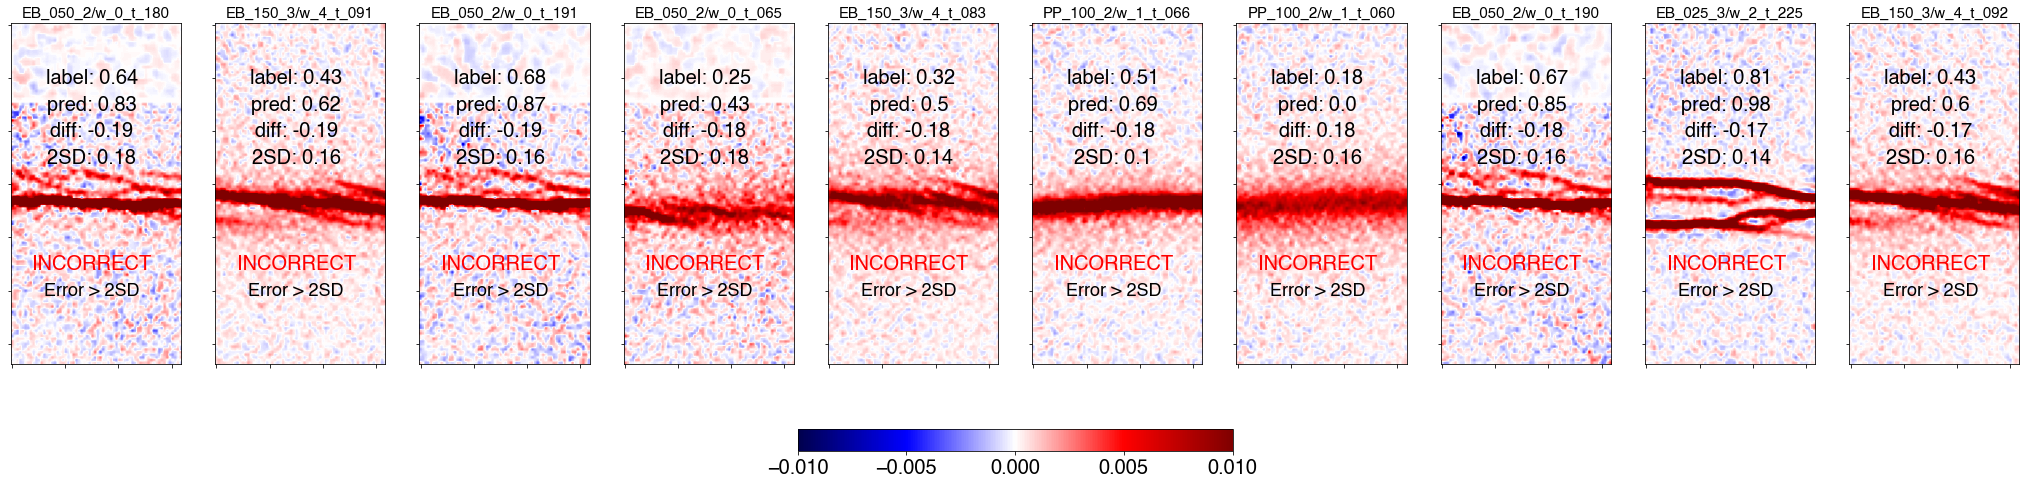

In [31]:
plotting_EXP_curl(test_generator, test_pred, test_label, test_SD, 'test', 20, 10)

size_data_all: 3064
size_data_meetTS: 182
custom_2SD_Accuracy 94.06005221932115 %
pred_outlier:  [0.72 0.75 0.76 0.77 0.67 0.65 0.18 0.64 0.74 0.74]
truth_outlier:  [0.24 0.43 0.45 0.46 0.38 0.36 0.44 0.38 0.48 0.48]
Top_nth_Outier > 2SD:  0 - 10
EB_150_2/0.24_0.09_win_1_t_087_EB_150_2_cfuv.npy
EB_150_2/0.24_0.09_win_1
EB_150_2/0.43_0.12_win_1_t_096_EB_150_2_cfuv.npy
EB_150_2/0.43_0.12_win_1
EB_150_2/0.45_0.11_win_1_t_093_EB_150_2_cfuv.npy
EB_150_2/0.45_0.11_win_1
EB_150_2/0.46_0.10_win_1_t_098_EB_150_2_cfuv.npy
EB_150_2/0.46_0.10_win_1
EB_150_3/0.38_0.12_win_0_t_084_EB_150_3_cfuv.npy
EB_150_3/0.38_0.12_win_0
EB_150_2/0.36_0.12_win_1_t_084_EB_150_2_cfuv.npy
EB_150_2/0.36_0.12_win_1
EB_025_2/0.44_0.11_win_4_t_066_EB_025_2_cfuv.npy
EB_025_2/0.44_0.11_win_4
EB_150_3/0.38_0.11_win_0_t_081_EB_150_3_cfuv.npy
EB_150_3/0.38_0.11_win_0
EB_150_2/0.48_0.10_win_1_t_100_EB_150_2_cfuv.npy
EB_150_2/0.48_0.10_win_1
EB_150_2/0.48_0.11_win_1_t_099_EB_150_2_cfuv.npy
EB_150_2/0.48_0.11_win_1


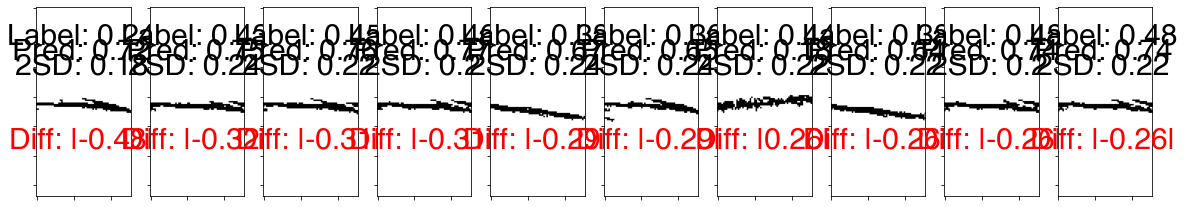

In [32]:
plotting_EXP(eval_generator, eval_pred, eval_label, eval_SD, 'eval', 0, 10)

In [33]:
def plotting_criteria_EXP(generator, pred, label, SD, mode, top_ith, num_sample):
      ## selecting outliers 
    y= pred.flatten()
    x= label
    if len(x) == len(y):
        print('size_data_all:',len(x))
#     idx = np.logical_and(np.abs(y-x) < 2*SD, x <0.55)
    idx = np.logical_and(y>0.9, y <0.99)
    print('size_data_meetTS:', np.sum(idx))
    print('%meet_criteria',(1-np.sum(idx)/len(x))*100, '%' )
    
  
    pred_outlier = np.round(y[idx],2)
    truth_outlier =np.round(x[idx],2)
    diff = np.round(np.abs(pred_outlier - truth_outlier),2)

        ##indexing from large to small for outlier 
    outlier_idx = np.argsort(diff)[::-1]
    y_outlier = pred_outlier[outlier_idx]
    x_outlier = truth_outlier[outlier_idx]
    offset_outlier = np.round(x_outlier-y_outlier,2)
        ## print top rank (num_sample) by the size of errors
    print('pred_outlier: ', y_outlier[top_ith:top_ith+num_sample])
    print('truth_outlier: ', x_outlier[top_ith:top_ith+num_sample])
    
    ##creating fault map of those outliers 
    CMAP = plt.cm.binary
    minCMAP = 0
    maxCMAP = 1
    ncols = num_sample
    print('Top_nth_Outier > 2SD: ', top_ith, '-', top_ith+ncols)
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(20,10))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
#     mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
#     cbar = fig.colorbar(mappable, ax = axs.ravel().tolist(), 
#                     orientation='horizontal', fraction=0.05)
#     cbar.ax.tick_params(axis='x', labelsize=20)      
    for i in range(ncols):
        filename = generator.filenames[:len(pred)][idx][outlier_idx][top_ith:top_ith+ncols][i]
        print(filename)
        fig_title = (filename[0:24])
        print(fig_title)
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
        prediction = y_outlier[top_ith:top_ith+ncols]
        label = x_outlier[top_ith:top_ith+ncols]
        offset = offset_outlier[top_ith:top_ith+ncols]
        two_SD = 2*SD[idx][outlier_idx][top_ith:top_ith+ncols]
        result = np.abs(offset) < np.round(2*SD[idx][outlier_idx][top_ith:top_ith+ncols],2)
        EXP = str(filename[0:8]) + '/w'+ str(filename[22:30])
        
        FontSize = 30
        
        text_label = axs[i].text(30,20, 'Label: ' 
                                     + str(label[i]), 
                                     fontsize =FontSize, 
                                     ha="center", va="center")
        text_prediction = axs[i].text(30,30, 'Pred: ' + str(prediction[i]), 
                                      fontsize =FontSize,
                                       ha="center", va="center")
        text_2SD = axs[i].text(30,40, '2SD: ' + str(two_SD[i]), 
                                      fontsize =FontSize,
                                       ha="center", va="center")

        if result[i] == True:
            text_result = axs[i].text(30,90, 'Diff: |'  + str(offset[i]) + '|' , 
                                fontsize =FontSize, ha="center", 
                                      va="center", color="b")
        else:
            text_result = axs[i].text(30,90, 'Diff: |'  + str(offset[i]) + '|' ,
                                fontsize =FontSize, ha="center", 
                                      va="center", color="r")
        axs[i].imshow(data[:, :, 1], norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )

size_data_all: 1532
size_data_meetTS: 70
%meet_criteria 95.43080939947781 %
pred_outlier:  []
truth_outlier:  []
Top_nth_Outier > 2SD:  120 - 125


IndexError: index 0 is out of bounds for axis 0 with size 0

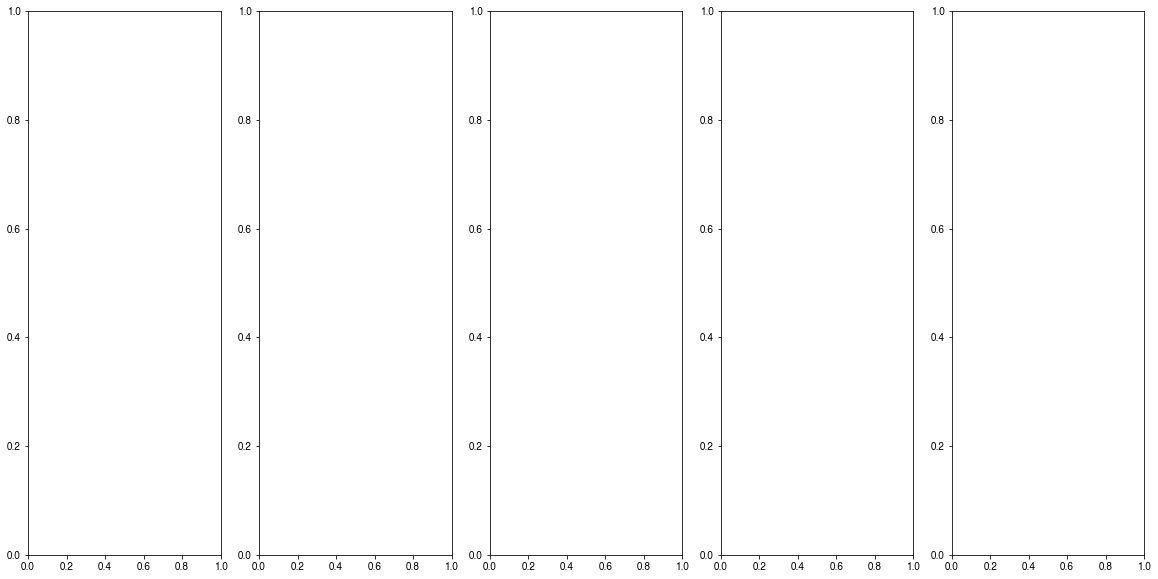

In [34]:
plotting_criteria_EXP(test_generator, test_pred, test_label, test_SD, 'test',120, 5)

# Above cells need fixing code and need to incorporate curl map

In [35]:
def create_dictionary(EXP_list): 
    EXP_Dict = {}
    for e in EXP_list:
        filename_list = np.loadtxt(DATA_DIR + F_MASTER + '/' + str(e) +'.txt',dtype='str')
        KE_label_list = np.array([float(f.split('/')[-1][0:4]) for f in filename_list])
        SD_list = np.array([float(f.split('/')[-1][5:9]) for f in filename_list])
        win_list = np.array([int(f.split('win_')[-1][0:1]) for f in filename_list])
        time_list = np.array([int(f.split('t_')[-1][0:3]) for f in filename_list])
        sliced_npy_List =[]
        for i in range(len(filename_list)):
            sliced_npy_dict = {'fn':filename_list[i], 'KE':KE_label_list[i],
                              'SD': SD_list[i],'w': win_list[i], 't': time_list[i]}
            sliced_npy_List.append(sliced_npy_dict)
        combo = np.vstack((KE_label_list,SD_list,win_list,time_list))
        sliced_npy_List.append(combo)
        EXP_Dict[str(e)] = sliced_npy_List        
    return EXP_Dict

In [36]:
EP_EXP_LIST = ['EB_025_1','EB_025_2','EB_025_3',
           'EB_050_1','EB_050_2','EB_050_3',
           'EB_150_1','EB_150_2','EB_150_3',
           'PP_025_1','PP_025_2',
           'PP_050_1','PP_050_2',
           'PP_100_1','PP_100_2',
           'PP_150_1']

In [37]:
EXP_Dict = create_dictionary(EP_EXP_LIST)
EXP_to_plot = 'EB_150_2'
time_to_plot = 70
print('len_of_Dict:', len(EXP_Dict[EXP_to_plot]))

len_of_Dict: 676


In [38]:
#manual user pick slide
#Plot Tool for a specific Experiment Time Slice, which will show full ROI
#Must run previous cell to obtain 'ltp_limit'
#Pick index s from the order of selected slices that fit the criteria for KE_label 

def label_slice_by_time(EXP_Dict, EXP_to_plot, time_to_plot):
    label_slice_view = []
    blind_test_list = []
    for slice_sample in EXP_Dict[str(EXP_to_plot)][0:-1]:
        if slice_sample['t'] == time_to_plot:
            label_slice_view.append(slice_sample)
            blind_test_list.append(slice_sample['fn'])
            blind_test_path = DATA_DIR + ML_EXP + 'blind_test_master_'+str(EXP_to_plot) +'_' + str(time_to_plot)+ '.txt'
            np.savetxt(blind_test_path, blind_test_list, fmt="%s")
    return label_slice_view                                       

def blind_pred(EXP_to_plot, time_to_plot):
    blind_master = 'blind_test_master_'+str(EXP_to_plot) +'_' + str(time_to_plot)+ '.txt' 
    blind_test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, blind_master, 
                                   batch_size = 1, 
                                   data_dir=DATA_DIR, shuffle = False)
    # print(blind_test_generator[2][1][0][0])
    pred = best_model.predict(x=blind_test_generator)
    blind_pred = (np.round(np.hstack(pred.flatten()),2))
    return blind_pred
                                  
def plot_curl(label_slice_view, EXP_to_plot, time_to_plot):
    ncols = 5
    #plotting fault map from selected time slice for the whole ROI (w_0,w_1,w_2,w_3,w_4)
    
    CMAP = plt.cm.seismic
    minCMAP = -0.02
    maxCMAP = 0.02
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(16,6))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    fig.colorbar(mappable, ax = axs.ravel().tolist(), fraction=.015)
    fig.suptitle('EXP: ' + str(EXP_to_plot),fontsize = 20)
    axs[0].set_ylabel('Time: ' + str(time_to_plot),fontsize = 20)
    
    Pred = blind_pred(EXP_to_plot, time_to_plot)
    
    for i in range(ncols):
        filename = label_slice_view[i]['fn']
        KE = float(filename.split('/')[-1][0:4])
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
#         axs[i].set_title('KE = ' + str(KE),fontsize = 15)
        text_label = axs[i].text(30,30, 'Label: ' + str(KE), fontsize =15,
                                 ha="center", va="center")
        text_pred = axs[i].text(30,40, 'Pred: ' + str(Pred[i]), fontsize =15,
                           ha="center", va="center")
        axs[i].imshow(data[:, :, 0],norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )

def plot_fault_map(label_slice_view, EXP_to_plot, time_to_plot):
    ncols = 5
    CMAP = plt.cm.binary
    minCMAP = 0
    maxCMAP = 1
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(16,6))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    fig.colorbar(mappable, ax = axs.ravel().tolist(), fraction=.015)
    fig.suptitle('EXP: ' + str(EXP_to_plot),fontsize = 20)
    axs[0].set_ylabel('Time: ' + str(time_to_plot),fontsize = 20)
    
    Pred = blind_pred(EXP_to_plot, time_to_plot)
    print('average_pred:', np.average(Pred))
    print(Pred)
    
    for i in range(ncols):
        filename = label_slice_view[i]['fn']
        KE = float(filename.split('/')[-1][0:4])
        Preds = Pred[i]
        Diff = np.abs(KE-Preds)
        SD = float(filename.split('/')[-1][5:9])
        result = np.abs(Diff) < 2*SD
        print(result)
        
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
         
        text_label = axs[i].text(30,20, 'Label: ' + str(KE), fontsize =15,
                                 ha="center", va="center")
        text_pred = axs[i].text(30,30, 'Pred: ' + str(Preds), fontsize =15,
                           ha="center", va="center")
        text_diff = axs[i].text(30,40, 'Diff: ' + str(np.round(np.abs(Preds-KE),2)), fontsize =15,
                                 ha="center", va="center")
        text_2SD = axs[i].text(30,50, '2SD: ' + str(2*SD), fontsize =15,
                                 ha="center", va="center")
        
        if result == True:
            text_result = axs[i].text(30,90, 'CORRECT', fontsize =20,
                           ha="center", va="center", color="b")
            Error = axs[i].text(30,100, 'Error < 2SD', fontsize =18,
                           ha="center", va="center")
        else:
            text_result = axs[i].text(30,90, 'INCORRECT', fontsize =20,
                           ha="center", va="center", color="r")
            Error = axs[i].text(30,100, 'Error > 2SD', fontsize =18,
                           ha="center", va="center")
            
        axs[i].imshow(data[:, :, 1],norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )

def plot_AOI_by_time(EXP_Dict, EXP_to_plot, time_to_plot):
    label_slice_view = label_slice_by_time(EXP_Dict, EXP_to_plot, time_to_plot)
    plot_curl(label_slice_view, EXP_to_plot, time_to_plot)
    plot_fault_map(label_slice_view, EXP_to_plot, time_to_plot)

5
5
5
5
average_pred: 0.584
[0.67 0.63 0.55 0.48 0.59]
True
True
True
True
True


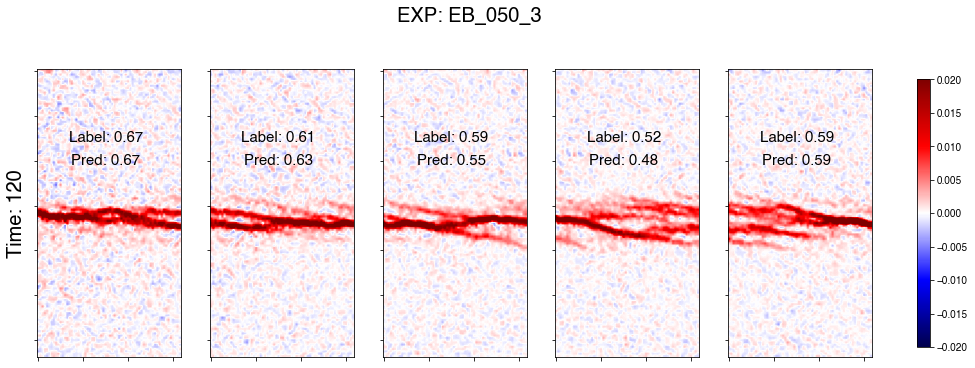

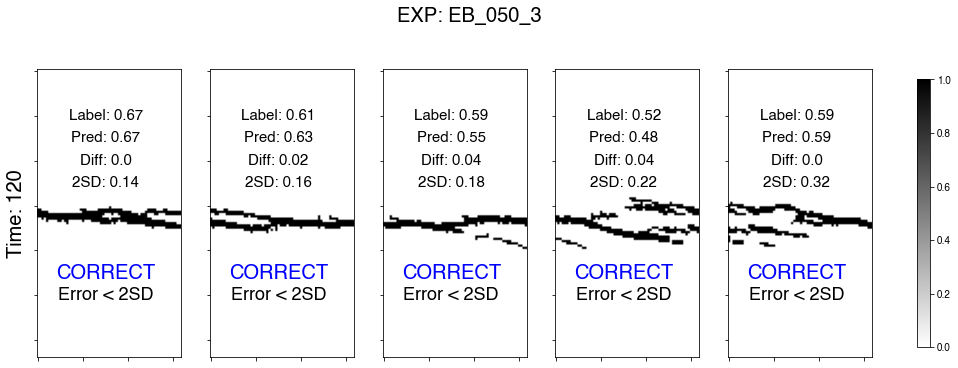

In [39]:
EXP_Dict = create_dictionary(EP_EXP_LIST)
EXP_to_plot = 'EB_050_3'
time_to_plot = 120
label_slice_by_time(EXP_Dict, EXP_to_plot, time_to_plot)
plot_AOI_by_time(EXP_Dict, EXP_to_plot, time_to_plot)

In [40]:
def plot_fault_map_simple(label_slice_view, EXP_to_plot, time_to_plot):
    ncols = 5
    CMAP = plt.cm.binary
    minCMAP = 0
    maxCMAP = 1
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(16,6))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    
    Pred = blind_pred(EXP_to_plot, time_to_plot)
    print('average_pred:', np.average(Pred))
    print(Pred)
    
    
    for i in range(ncols):
        filename = label_slice_view[i]['fn']
        KE = float(filename.split('/')[-1][0:4])
        Preds = Pred[i]
        Diff = np.abs(KE-Preds)
        SD = float(filename.split('/')[-1][5:9])
        result = np.abs(Diff) < 2*SD
        print(result)
        
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
            
        axs[i].imshow(data[:, :, 1],norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )
    plt.savefig('exp_panel.svg', dpi=900, edgecolor='w',
        orientation='portrait', format='svg',
        transparent=False, bbox_inches=None, pad_inches=0.1)

5
5
average_pred: 0.54399997
[0.6  0.44 0.61 0.49 0.58]
True
True
True
True
True


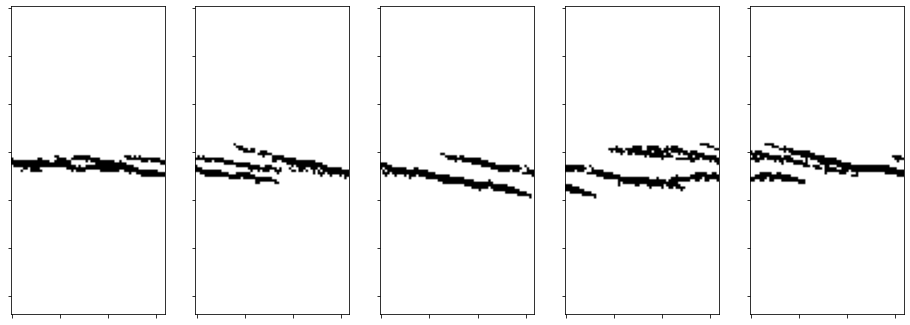

In [41]:
EXP_Dict = create_dictionary(EP_EXP_LIST)
EXP_to_plot = 'EB_050_3'
time_to_plot = 100
label_slice_view = label_slice_by_time(EXP_Dict, EXP_to_plot, time_to_plot)
plot_fault_map_simple(label_slice_view, EXP_to_plot, time_to_plot)


In [42]:
#manual user pick slide
#Plot Tool for a specific Experiment Time Slice, which will show full ROI
#Must run previous cell to obtain 'ltp_limit'
#Pick index s from the order of selected slices that fit the criteria for KE_label 

def label_slice_by_time(EXP_Dict, EXP_to_plot, time_list):
    label_slice_view = []
    blind_test_list = []
    for time_to_plot in time_list:
        for slice_sample in EXP_Dict[str(EXP_to_plot)][0:-1]:
            if slice_sample['t'] == time_to_plot:
                label_slice_view.append(slice_sample)
                blind_test_list.append(slice_sample['fn'])
        blind_test_path = ML_EXP + 'blind_test_master_'+str(EXP_to_plot) +'_' + str(time_to_plot)+ '.txt'
        np.savetxt(blind_test_path, blind_test_list, fmt="%s")
    return label_slice_view                                       

def blind_pred(EXP_to_plot, time_list):
    blind_pred_list = []
    for time_to_plot in time_list:
        blind_master = 'blind_test_master_'+str(EXP_to_plot) +'_' + str(time_to_plot)+ '.txt' 
        blind_test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, blind_master, 
                                       batch_size = 1, 
                                       data_dir=DATA_DIR, shuffle = False)
        # print(blind_test_generator[2][1][0][0])
        pred = best_model.predict(x=blind_test_generator)
        blind_pred = (np.round(np.hstack(pred.flatten()),2))
        blind_pred_list.append(blind_pred)
    return blind_pred_list
                                  
def plot_blind_test(label_slice_view, EXP_to_plot, time_to_plot):
    ncols = 5
    #plotting fault map from selected time slice for the whole ROI (w_0,w_1,w_2,w_3,w_4)
    
    CMAP = plt.cm.seismic
    minCMAP = -0.02
    maxCMAP = 0.02
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(16,6))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    fig.colorbar(mappable, ax = axs.ravel().tolist(), fraction=.015)
    fig.suptitle('EXP: ' + str(exp_to_plot),fontsize = 20)
    axs[0].set_ylabel('Time: ' + str(time_to_plot),fontsize = 20)
    Pred = blind_pred(EXP_to_plot, time_to_plot)
    for i in range(ncols):
        filename = label_slice_view[i]['fn']
        KE = float(filename.split('/')[-1][0:4])
        data = np.load(DATA_DIR + 'slice_npy_SD/' + filename)
#         axs[i].set_title('KE = ' + str(KE),fontsize = 15)
        text_label = axs[i].text(30,30, 'Label: ' + str(KE), fontsize =15,
                                 ha="center", va="center")
        text_pred = axs[i].text(30,40, 'Pred: ' + str(Pred[i]), fontsize =15,
                           ha="center", va="center")
        axs[i].imshow(data[:, :, 0],norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )

def plot_fault_map(label_slice_view, EXP_to_plot, time_to_plot):
    ncols = 5
    CMAP = plt.cm.binary
    minCMAP = 0
    maxCMAP = 1
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(16,6))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    fig.colorbar(mappable, ax = axs.ravel().tolist(), fraction=.015)
    fig.suptitle('EXP: ' + str(exp_to_plot),fontsize = 20)
    axs[0].set_ylabel('Time: ' + str(time_to_plot),fontsize = 20)
    Pred = blind_pred(EXP_to_plot, time_to_plot)
    print('average_pred:', np.average(Pred))
    for i in range(ncols):
        filename = label_slice_view[i]['fn']
        KE = float(filename.split('/')[-1][0:4])
#         Pred = Pred[i]
#         Diff = np.abs(KE-Pred)
        SD = float(filename.split('/')[-1][5:9])*2
        data = np.load(DATA_DIR + 'slice_npy_SD/' + filename)
        
        text_label = axs[i].text(30,20, 'Label: ' + str(KE), fontsize =15,
                                 ha="center", va="center")
        text_pred = axs[i].text(30,30, 'Pred: ' + str(Pred[i]), fontsize =15,
                           ha="center", va="center")
        text_diff = axs[i].text(30,40, 'Diff: ' + str(np.round(np.abs(Pred[i]-KE),2)), fontsize =15,
                                 ha="center", va="center")
        text_2SD = axs[i].text(30,50, '2SD: ' + str(SD), fontsize =15,
                                 ha="center", va="center")
        axs[i].imshow(data[:, :, 1],norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )

def plot_AOI_by_time(EXP_Dict, EXP_to_plot, time_to_plot):
    label_slice_view = label_slice_by_time(EXP_Dict, EXP_to_plot, time_to_plot)
    plot_KE(label_slice_view, EXP_to_plot, time_to_plot)
    plot_fault_map(label_slice_view, EXP_to_plot, time_to_plot)

In [43]:
def plotting_with_TS_H(generator_LSP, mode, EXP, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
        if len(pred) == len(label):
            print(len(pred))
        idx = np.abs(pred-label) > 2*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 2)
        

        ax.plot(pred, label,'o', label=f'Correct')
        ax.plot(pred[idx], label[idx], 'ro', label=f'Incorrect')
        ax.plot([0, 1], [0, 1], 'k', alpha=0.2)
        ax.set_title(str(m), fontsize = 24)
        text_error = '% error (>2SD) = ' +str(error_pct) + '%'
        ax.text(0.7, 0.1, text_error, fontsize = 12,
                horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='best')
        ax.set_xlabel('Truth', fontsize =18)
    axs[0].set_ylabel('Prediction', fontsize = 18)

    plt.tight_layout()
    plt.show